In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as lng
import scipy.io as io
from sklearn.ensemble import BaggingClassifier, AdaBoostRegressor
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn import linear_model 
import warnings # to silence convergence warnings

In [2]:
data_file = "processed_data.csv"
d = pd.read_csv(data_file)

## Vi bliver ikke bedømt på fly hvor der er nul passagerer
d = d[d.LoadFactor != 0]

## Splits
d.ScheduleTime = pd.to_datetime(d.ScheduleTime)
ix_val = ((d.ScheduleTime.dt.year==2022) & (d.ScheduleTime.dt.month!=1))

## Fjerner udvalgte kolonner da de allerede er blevet encoded som sin/cos
## Eller hvis kolonnen kun indehodler identiske værdier
X_cols = list(d.columns)
X_cols.remove("LoadFactor")
X_cols.remove("ScheduleTime")
X_cols.remove('Hour')
X_cols.remove('Date')
X_cols.remove('QuarterEnd')
X_cols.remove('MonthEnd')
X_cols.remove('TimeToQuarterEnd')
X_cols.remove('TimeToMonthEnd')
X_cols.remove('Holiday')

## One-hot encoding
d_one_hot = pd.get_dummies(d[X_cols],)

## Alternativ til One-hot encoding af features med mange levels
## Der udregnes middelværdi og precision (inverse variance) af LoadFactor, for hvert
## unikt level. Eks: For alle observationer flynummer SA201, udregnes der middelværdi og precision
## Disse summary metrics tilføjes som features
for col in ["FlightNumber2","Airline","Sector","Destination","AircraftType"]:
    mu = d[~ix_val].groupby(col)["LoadFactor"].mean()
    prec = 1/d[~ix_val].groupby(col)["LoadFactor"].var()

    mu = d[col].map(mu)
    prec = d[col].map(prec)
    mu[mu.isna()|np.isinf(mu)] = 0
    prec[prec.isna()|np.isinf(prec)] = 0

    col_mean = "mean_"+col
    col_prec = "prec_"+col

    d_one_hot[col_mean] = mu
    d_one_hot[col_prec] = prec


cols_mu = d_one_hot.columns.str.startswith("_mean")
cols_prec = d_one_hot.columns.str.startswith("_prec")

cols_flight_numbers = d_one_hot.columns.str.startswith("FlightNumber2")
cols_airline = d_one_hot.columns.str.startswith("Airline")
cols_sector = d_one_hot.columns.str.startswith("Sector")
cols_destination = d_one_hot.columns.str.startswith("Destination")
cols_aircraft = d_one_hot.columns.str.startswith("AircraftType")
cols_one_hot = (cols_flight_numbers | cols_airline | cols_sector | cols_destination | cols_aircraft)


## Standardisering
X = (d_one_hot-d_one_hot.mean(axis=0))/d_one_hot.std(axis=0)


## To datamatrixer: En med alt one-hot encoded og en anden hvor mean+precision benyttes
## for udvalgte features.
X_full_cols = d_one_hot.columns[~(cols_mu | cols_prec)]
X_small_cols = d_one_hot.columns[~cols_one_hot]

X_full = X[X_full_cols].to_numpy()
X_small = X[X_small_cols].to_numpy()
y = d.LoadFactor.iloc[:].to_numpy()

N, P_full = X_full.shape
N, P_small = X_small.shape

In [3]:
## Metrics

def relative_difference(y,y_hat):
    return (y-y_hat)/y
def accuracy(y,y_hat):
    return (1-np.abs(relative_difference(y,y_hat)))*100

## Trees

Fitting 2 folds for each of 40 candidates, totalling 80 fits
best estimator: DecisionTreeRegressor(min_samples_leaf=36)


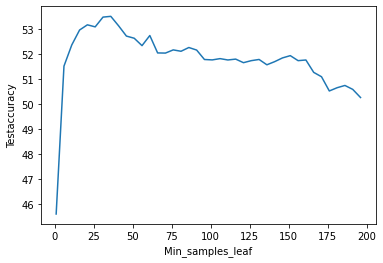

In [73]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer


trns = lambda x: x
inv_trns = lambda x: x

def accuracy_score(y_true, y_pred):
    return accuracy(y_true,inv_trns(y_pred)).mean()

score = make_scorer(accuracy_score, greater_is_better=True)


dtree=DecisionTreeRegressor()

candidates = range(1,200,5)

X_train = X_small[~ix_val,:]
y_train = y[~ix_val]
X_val = X_small[ix_val,:]
y_val = y[ix_val]

param_grid = {
    'min_samples_leaf': candidates,
    
}
tscv = TimeSeriesSplit(n_splits=2)
cv_grid = GridSearchCV(estimator = dtree, param_grid = param_grid, cv = tscv, verbose=2, n_jobs=-1,scoring=score)

# Fit the grid search model
cv_grid.fit(X_train, trns(y_train))

#plot the results
plt.plot(candidates,cv_grid.cv_results_['mean_test_score'])
plt.xlabel('Min_samples_leaf')
plt.ylabel('Testaccuracy')
print(f'best estimator: {cv_grid.best_estimator_}')

In [75]:
cv_grid.param_grid

{'min_samples_leaf': range(1, 200, 5)}

Accuracy train
60.25019290832795
Accuracy val
60.07395823625822


c:\Users\lukas\Git\Studie\02582_Computational_Data_Analysis\CDA-case-env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Validation predictions')

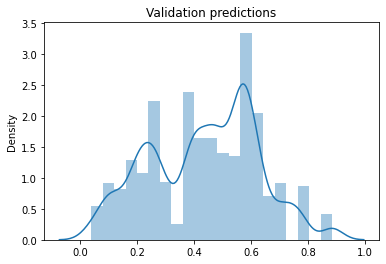

In [19]:
from sklearn import tree
dtree=DecisionTreeRegressor(min_samples_leaf=61)
dtree.fit(X_train, trns(y_train))

print("Accuracy train")
yhat = inv_trns(dtree.predict(X_train))
print(accuracy(y_train,yhat).mean())

print("Accuracy val")
yhat = inv_trns(dtree.predict(X_val))
print(accuracy(y_val,yhat).mean())

sns.distplot(yhat)
plt.title("Validation predictions")



Accuracy before: 60.07
Accuracy with threshhold of 0.0031622776601683794: 60.07


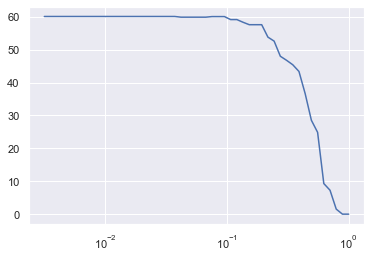

In [20]:
threshholds = np.logspace(-2.5,0,num=50)
accuracies = np.zeros(threshholds.shape)
for i,thresh in enumerate(threshholds):
    pred_thresh = yhat*(yhat>thresh)
    accuracies[i] = accuracy(y_val,pred_thresh).mean()

sns.set_theme()
plt.semilogx(threshholds,accuracies)

print("Accuracy before: {:.4}".format(accuracy(y_val,yhat).mean()))
best_ix = np.argmax(accuracies)
print("Accuracy with threshhold of {:}: {:.4}".format(threshholds[best_ix],accuracies[best_ix]))

## Dummy predictor

In [8]:
from sklearn.dummy import DummyRegressor

dummy_clf = DummyRegressor(strategy='mean')
dummy_clf.fit(X,y)
y_hat = dummy_clf.predict(X)
# Check for Model Accuracy
print("without log transform",accuracy(y,y_hat).mean())

dummy_clf = DummyRegressor(strategy='mean')
dummy_clf.fit(X,np.log(y))
y_hat = np.exp(dummy_clf.predict(X))
# Check for Model Accuracy
print("with log transform",accuracy(y,y_hat).mean())




without log transform -22.112453290156218
with log transform -1.946038032479979


# KNN

Best 7 neighbors, acc: 59.91806257298028


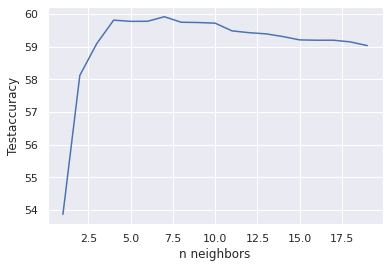

In [16]:
from sklearn.neighbors import KNeighborsRegressor
trns = lambda x: np.log(x)
inv_trns = lambda x: np.exp(x)

candidates = range(1,20,1)

scores = []
for candidate in candidates:
    model = KNeighborsRegressor(n_neighbors=candidate)
    # Fit the grid search model
    model.fit(X_train,trns(y_train))
    yhat = inv_trns(model.predict(X_val))
    scores.append(accuracy(y_val,yhat).mean())

#plot the results
plt.plot(candidates,scores)
plt.xlabel('n neighbors')
plt.ylabel('Testaccuracy')
ix = np.argmax(scores)
print("Best",candidates[ix],"neighbors, acc:",scores[ix])


In [17]:
model = KNeighborsRegressor(n_neighbors=7)
model.fit(X_train,trns(y_train))
yhat = inv_trns(model.predict(X_val))




Flights with very low true loadfactor cause a huge negative relative difference due to division by something close to 0.

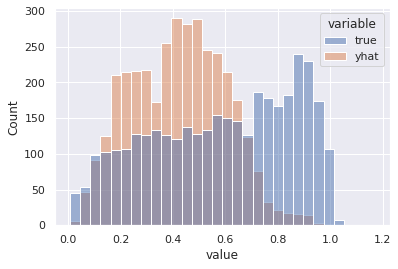

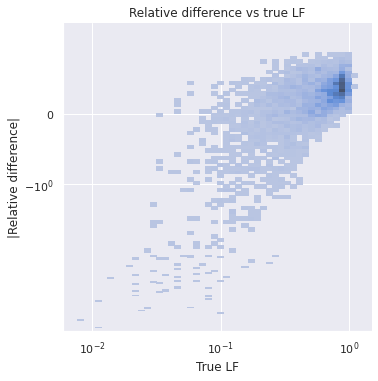

In [20]:
    
result = pd.DataFrame({"true":y_val,"yhat":yhat}).melt()
rd = relative_difference(y_val,yhat)
sns.histplot(data=result,x="value",hue="variable")

sns.displot(x=y_val,y=rd,log_scale=(True, False))
plt.xlabel("True LF")
plt.ylabel("|Relative difference|")
plt.title("Relative difference vs true LF")
plt.yscale('symlog')


An example of the shitty case:

In [21]:
acc = accuracy(y_val,yhat)
print("Relative difference:",np.min(acc))
d.iloc[np.argmin(acc),:]

Relative difference: -662.4377537316643


ScheduleTime                  2021-03-27 14:50:00
Airline                                        CN
Destination                                   EST
AircraftType                                  AT7
FlightType                                      J
Sector                                         US
SeatCapacity                                   72
LoadFactor                               0.902778
Hour                                           14
Date                                   2021-03-27
Holiday                                      True
Weekday                                  Saturday
QuarterEnd          2021-03-31 23:59:59.999999999
MonthEnd            2021-03-31 23:59:59.999999999
TimeToQuarterEnd                                4
TimeToMonthEnd                                  4
TimeCos                                 -0.737277
TimeSin                                  -0.67559
DayCos                                   0.669131
DaySin                                  -0.743145


## A simple yet effective fix
All flights that are succeptible to having a very load loadfactor, we simply predict to have 0 passengers

Accuracy before: 59.92
Accuracy with threshhold of 0.06707035611184306: 60.05


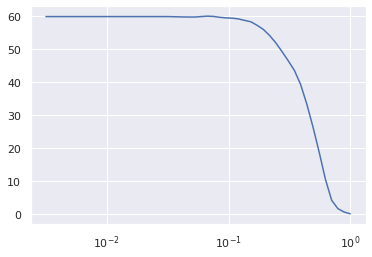

In [22]:
threshholds = np.logspace(-2.5,0,num=50)
accuracies = np.zeros(threshholds.shape)
for i,thresh in enumerate(threshholds):
    pred_thresh = yhat*(yhat>thresh)
    accuracies[i] = accuracy(y_val,pred_thresh).mean()

sns.set_theme()
plt.semilogx(threshholds,accuracies)

print("Accuracy before: {:.4}".format(accuracy(y_val,yhat).mean()))
best_ix = np.argmax(accuracies)
print("Accuracy with threshhold of {:}: {:.4}".format(threshholds[best_ix],accuracies[best_ix]))

## No transform and exp transform is shitty

In [406]:
model = KNeighborsRegressor(n_neighbors=7)
model.fit(X_small,np.exp(y))
y_pred = model.predict(X_small)
print(accuracy(y,np.log(y_pred)).mean())

12.810892871283368


In [407]:
model = KNeighborsRegressor(n_neighbors=7)
model.fit(X_small,y)
y_pred = model.predict(X_small)
print(accuracy(y,y_pred).mean())

19.60126571919451


## Inverse transformation is alright

In [28]:
model = KNeighborsRegressor(n_neighbors=7)
trns = lambda x: 1/x
inv_trns = lambda x: 1/x

model.fit(X_train,trns(y_train))
yhat = inv_trns(model.predict(X_val))
print(accuracy(y_val,yhat).mean())

59.01639217570004


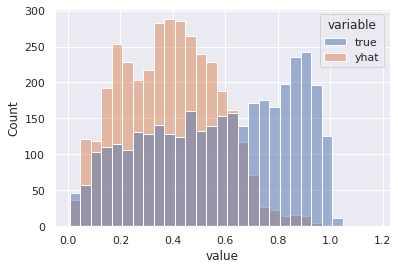

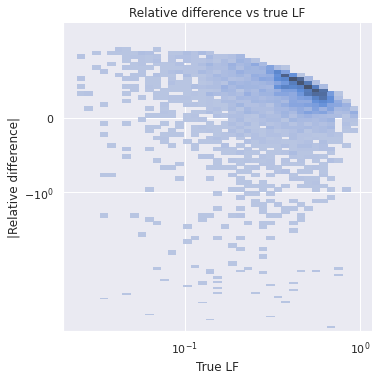

In [30]:
result = pd.DataFrame({"true":y_val,"yhat":yhat}).melt()
rd = relative_difference(y_val,yhat)
sns.histplot(data=result,x="value",hue="variable")

sns.displot(x=yhat,y=rd,log_scale=(True, False))
plt.xlabel("True LF")
plt.ylabel("|Relative difference|")
plt.title("Relative difference vs true LF")
plt.yscale('symlog')

Little improvement by threshholding

Accuracy before: 59.02
Accuracy with threshhold of 0.0031622776601683794: 59.02


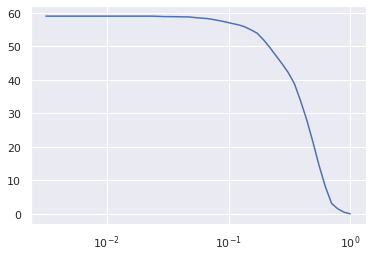

In [32]:
threshholds = np.logspace(-2.5,0,num=50)
accuracies = np.zeros(threshholds.shape)
for i,thresh in enumerate(threshholds):
    pred_thresh = yhat*(yhat>thresh)
    accuracies[i] = accuracy(y_val,pred_thresh).mean()

sns.set_theme()
plt.semilogx(threshholds,accuracies)

print("Accuracy before: {:.4}".format(accuracy(y_val,yhat).mean()))
best_ix = np.argmax(accuracies)
print("Accuracy with threshhold of {:}: {:.4}".format(threshholds[best_ix],accuracies[best_ix]))

## Boosting

### AdaBoost

Fitting 2 folds for each of 20 candidates, totalling 40 fits
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Fitting 2 folds for each

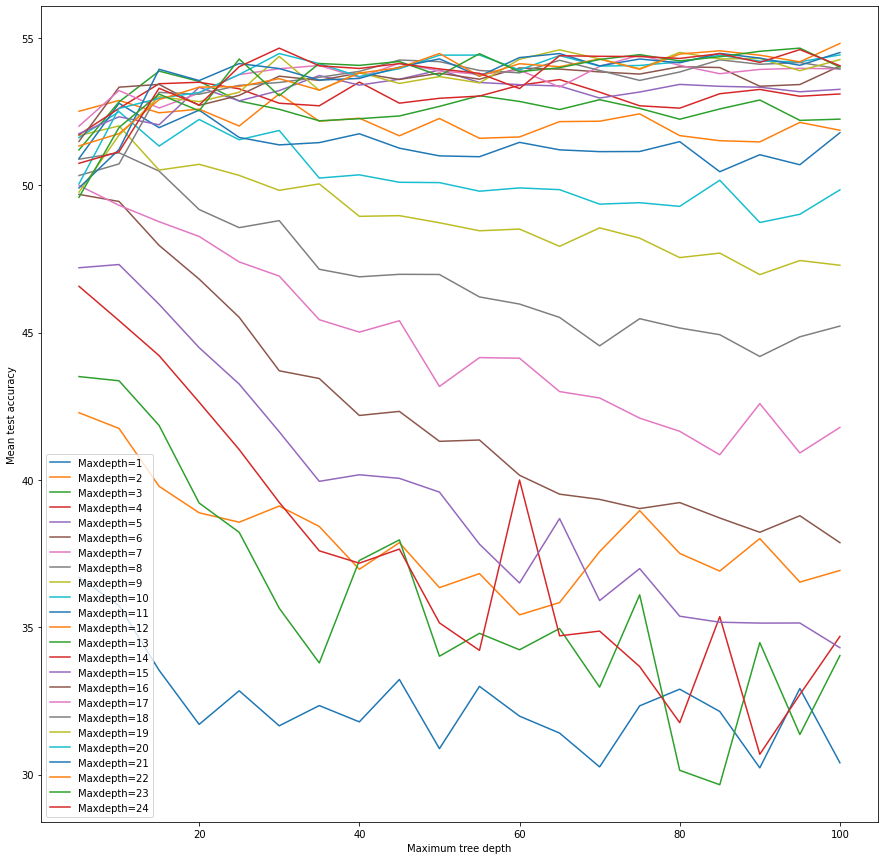

In [58]:
from sklearn.model_selection import TimeSeriesSplit
trns = lambda x: x
inv_trns = lambda x: x

def accuracy_score(y_true, y_pred):
    return accuracy(y_true,inv_trns(y_pred)).mean()

score = make_scorer(accuracy_score, greater_is_better=True)

X_train = X_small[~ix_val,:]
y_train = y[~ix_val]
X_val = X_small[ix_val,:]
y_val = y[ix_val]



# Try to experiment with max_samples, max_features, number of modles, and other models
n_estimators = range(5,101, 5)
max_depth = range(1,25)

#We do an outer loop over max_depth here ourselves because we cannot include in the CV paramgrid.
#Notice this is not a "proper" way to select the best max_depth but for the purpose of vizuallizing behaviour it should do
test_acc = np.zeros((len(n_estimators), len(max_depth)))
for i in max_depth:
    
    # Create and fit an AdaBoosted decision tree
    boost = AdaBoostRegressor(DecisionTreeRegressor(max_depth = i), learning_rate= 1)

    params = {
        "n_estimators" : n_estimators,
        # "learning_rate" : np.arange(0.5, 2, .1)
    }
    
    tscv = TimeSeriesSplit(n_splits=2)
    boost_grid = GridSearchCV(boost, params, cv = tscv, n_jobs = -1, verbose = 2, scoring = score)

    # Fit the grid search model
    boost_grid.fit(X_train, y_train)


    test_acc[:,i-1] = boost_grid.cv_results_['mean_test_score']


fig, ax = plt.subplots(figsize=(15,15))

ax.plot(n_estimators, test_acc)
ax.set_xlabel('Maximum tree depth')
ax.set_ylabel('Mean test accuracy')
# ax.legend(['MaxDepth=1','MaxDepth=2','MaxDepth=3','MaxDepth=4','MaxDepth=5','MaxDepth=6','MaxDepth=7','MaxDepth=8','MaxDepth=9','MaxDepth=10'])
ax.legend(["Maxdepth="+ str(i) for i in max_depth])

In [64]:
print("best number of max depth: ", np.argmax(test_acc)+1)
n_estimators[np.argmax(test_acc[:, 20])]

best number of max depth:  478


100

In [65]:
boost = AdaBoostRegressor(DecisionTreeRegressor(max_depth = 20), learning_rate= 1, n_estimators=100)
boost.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=20),
                  learning_rate=1, n_estimators=100)

In [71]:
yhat = boost.predict(X_val)
# yhat *= yhat > 0.05
accuracy_score(y_val, yhat)

64.2902609063061

In [68]:
yhat.min()

0.0222222222222222

### XGBoost

In [22]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

X_train = X_small[~ix_val,:]
y_train = y[~ix_val]
X_val = X_small[ix_val,:]
y_val = y[ix_val]


tscv = TimeSeriesSplit(n_splits=2)
for train, test in tscv.split(X_train):
    print(train, test)


model = xgb.XGBRegressor()
max_depth = range(1,10)
param_search = {'max_depth' : max_depth}

tscv = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=param_search, scoring=score)
gsearch.fit(X_train, y_train)

[    0     1     2 ... 11928 11929 11930] [11931 11932 11933 ... 23859 23860 23861]
[    0     1     2 ... 23859 23860 23861] [23862 23863 23864 ... 35790 35791 35792]


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
             

best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


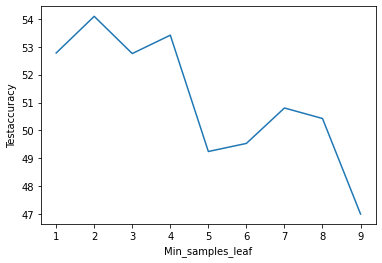

In [23]:
#plot the results
plt.plot(max_depth,gsearch.cv_results_['mean_test_score'])
plt.xlabel('Min_samples_leaf')
plt.ylabel('Testaccuracy')
print(f'best estimator: {gsearch.best_estimator_}')

In [26]:
model = xgb.XGBRegressor(max_depth = 2).fit(X_train, y_train)
accuracy_score(y_val, model.predict(X_val))

60.990034239606054

## LSTM

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, device = None):
        super().__init__()
        default_device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = default_device if device is None else device
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units, device=self.device).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units, device = self.device).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        # out *= out > 0.0031622776601683794

        return out

class FlightDataset(Dataset):
    def __init__(self, type = "train", sequence_length = 5, device = None):
        default_device = "cuda" if torch.cuda.is_available() else "cpu"
        device = default_device if device is None else device
        self.sequence_length = sequence_length
        if type == "train":
            self.X = X_train
            self.y = y_train
        elif type == "validation":
            self.X = X_val
            self.y = y_val

        self.X = torch.tensor(self.X, device = device).float()
        self.y = torch.tensor(self.y, device = device).float()

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self,i):
        # return self.X[i], self.y[i]
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

def loss_function(yhat, y):
    deviance = (y-yhat)/y
    accuracy = (1-torch.abs(deviance))*100
    return -torch.mean(accuracy)

In [48]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        # X, y = X.to(device = device), y.to(device = device)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output.to(device), y_star.to(device)), 0)

    return output

In [52]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train = X_small[~ix_val,:]
y_train = y[~ix_val]
X_val = X_small[ix_val,:]
y_val = y[ix_val]

train_loader = DataLoader(FlightDataset(), batch_size=3, shuffle=True)
test_loader = DataLoader(FlightDataset(type = "validation"), batch_size=3, shuffle=False)

learning_rate = 5e-5
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=X_train.shape[1], hidden_units=num_hidden_units)

print("Device: ", device)
model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_epochs = 20
train_accs = np.zeros((n_epochs))
test_accs = np.zeros((n_epochs))
for ix_epoch in range(n_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_accs[ix_epoch] = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_accs[ix_epoch] = test_model(test_loader, model, loss_function)
    print()

Device:  cuda
Epoch 0
---------
Train loss: -23.09335644193716
Test loss: -42.25805497477709

Epoch 1
---------
Train loss: -48.97318601629222
Test loss: -50.83253764748275

Epoch 2
---------
Train loss: -54.68954165243396
Test loss: -51.358019731435505

Epoch 3
---------
Train loss: -57.38367750453598
Test loss: -52.339843834845894

Epoch 4
---------
Train loss: -58.83760154328259
Test loss: -52.14131347426183

Epoch 5
---------
Train loss: -59.81374737929249
Test loss: -51.964969863709655

Epoch 6
---------
Train loss: -60.50191622152494
Test loss: -49.88563373955813

Epoch 7
---------
Train loss: -61.08957811303461
Test loss: -49.64326932114099

Epoch 8
---------
Train loss: -61.56604496419052
Test loss: -48.54564729564085

Epoch 9
---------
Train loss: -61.96857645884191
Test loss: -48.43481889232881

Epoch 10
---------
Train loss: -62.27433812917753
Test loss: -47.67789317290916

Epoch 11
---------
Train loss: -62.613058019749566
Test loss: -45.01279163102093

Epoch 12
---------
T

In [60]:
X, y = next(iter(train_loader))
X.shape

torch.Size([3, 5, 28])

In [49]:
eval_dataloader = DataLoader(FlightDataset("validation"))
yhat = predict(eval_dataloader, model).cpu()

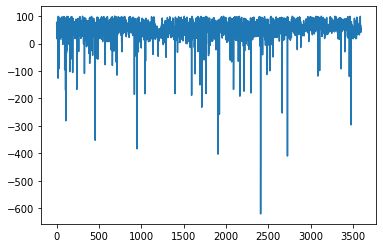

In [50]:
# plt.plot(yhat, alpha = .5)
# plt.plot(eval_dataloader.dataset.y.cpu()[::5], alpha = .5)
# plt.plot(-loss_function(yhat, eval_dataloader.dataset.y.cpu()))
plt.plot([-loss_function(i,j) for i,j in zip(yhat, eval_dataloader.dataset.y.cpu())])

In [35]:
eval_dataloader.dataset.y

tensor([0.2826, 0.6250, 0.1481,  ..., 0.8571, 0.6828, 0.8205], device='cuda:0')

In [84]:
import dill as pickle
gs = pickle.load( open("models/model_adaboost_data_summary_stats.pkl", "rb"))

In [89]:
gs["boost_grid"][0].best_estimator_

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=15),
                  learning_rate=1)

## Elastic net

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Text(0.5, 1.0, 'Crossvalidated MSE of Elastic Net Fit Alpha = 0.01')

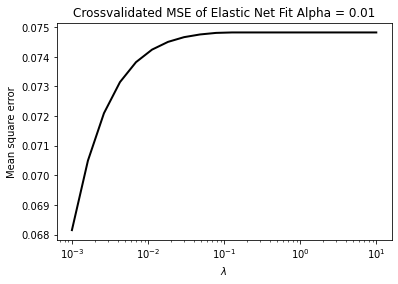

In [18]:
def accuracy_score(y_true, y_pred):
    return accuracy(y_true,y_pred).mean()

score = make_scorer(accuracy_score, greater_is_better=True)

X_train = X_small[~ix_val,:]
y_train = y[~ix_val]
X_val = X_small[ix_val,:]
y_val = y[ix_val]


# set up a range of lambdas and an alpha value
alpha = 0.01 # alpha = 1 corresponds to l1 penalty and lasso
lambdas = np.logspace(-3, 1, num=20)

with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
    warnings.simplefilter("ignore")

    #Run the elasticNet model. You can implement Crossvalidation yourself or look at ElasticNetCV
    model = linear_model.ElasticNetCV(
        cv = 5,
        l1_ratio=alpha, # called alpha in lecture
        alphas=lambdas,  # called lambda in lecture
        normalize = True,
        verbose = True
    )

    model = model.fit(X_train,y_train)
    
plt.figure()
plt.semilogx(model.alphas_, model.mse_path_.mean(axis=-1), 'k',label='Average across the folds', linewidth=2)
plt.xlabel(r'$\lambda$')
plt.ylabel('Mean square error')
plt.title('Crossvalidated MSE of Elastic Net Fit Alpha = %.2f' % alpha)

In [19]:
accuracy_score(y_val, model.predict(X_val))

12.67113272415441

In [15]:
model.predict(X_val).shape

(3596,)